KNN Analysis of May 2021 Divvy Data

In [1]:
# import packages
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.model_selection import cross_validate
import sklearn.metrics as metrics
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

In [2]:
# import data
data = pd.read_csv("Data/all-months-divvy-tripdata.csv")

C:\Users\Ryan Dauber\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (6,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
from datetime import datetime
from scipy.stats import binned_statistic
import math
startBin = data.shape[0] * [None]
start = data['start_hour']
#Bin the starting times
for i in range(0, start.shape[0]):
    if(start[i] <= 7):
        startBin[i] = 0
    elif(start[i] <= 10):
        startBin[i] = 2
    elif(start[i] <= 13):
        startBin[i] = 4
    elif(start[i] <=15):
        startBin[i] = 6
    elif(start[i] <= 19):
        startBin[i] = 8
    else:
        startBin[i] = 10
    


In [9]:
#Combine start and the log of duration into one dataframe
startAndDuration = [None] * len(startBin)
dataLog = np.log(data['duration'])
for i in range(0, len(startBin)):
    startAndDuration[i] = [startBin[i], dataLog[i]]
df = pd.DataFrame(startAndDuration)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
startAndDuration = df

C:\Users\Ryan Dauber\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [13]:
import sklearn
from sklearn.cluster import KMeans
from statistics import mean
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, silhouette_samples
startTemp = startAndDuration
num_iter = 10
totalMSE = [0] * num_iter
kMeansTotal = [0] * num_iter
sil_scores = [0] * num_iter
SSE = [0] * num_iter
for i in range(1, num_iter + 1):
    mseVals = []
    mse_pred = []
    #Kmeans model, i from [1,10]
    kModel = KMeans(n_clusters=i, random_state=5)
    kMeansVal = kModel.fit_predict(startTemp)
    
    if(i != 1): 
        #Calculate the silhouette score
        sil_score = silhouette_score(startTemp, kMeansVal)
        print(i, 'sil score: ', sil_score)
    kMeansTotal[i - 1] = kModel
    #Calculate the SSE for the iteration
    for j in range(0, len(startTemp)):
        index = kMeansVal[j]
        point = startTemp.iloc[j]
        center = kModel.cluster_centers_[index]
        xDist =  np.square(point[0] - center[0])
        yDist = np.square(point[1] - center[1])
        SSE[i - 1] += xDist + yDist

2 sil score:  0.5727517034643964
3 sil score:  0.4979397280149424
4 sil score:  0.4489496784563286
5 sil score:  0.4687034087519298
6 sil score:  0.4960737736447386
7 sil score:  0.5073072605072281
8 sil score:  0.5258684454031683
9 sil score:  0.544110716854694
10 sil score:  0.5623531923205849


cluster:  [[4.93220862 3.15347589]
 [8.68873128 3.07323285]
 [1.29628728 2.72901926]]


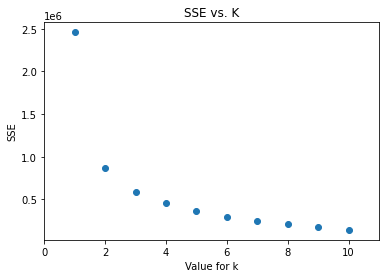

In [22]:
#Plot the data
arr = list(range(1, num_iter + 1))
plt.scatter(arr, SSE)
plt.xlim([0,11])
plt.xlabel('Value for k')
plt.ylabel('SSE')
plt.title('SSE vs. K')
print('cluster: ', kMeansTotal[2].cluster_centers_)

For n_clusters = 2 The average silhouette_score is : 0.5727517034643964
For n_clusters = 3 The average silhouette_score is : 0.4979397280149424


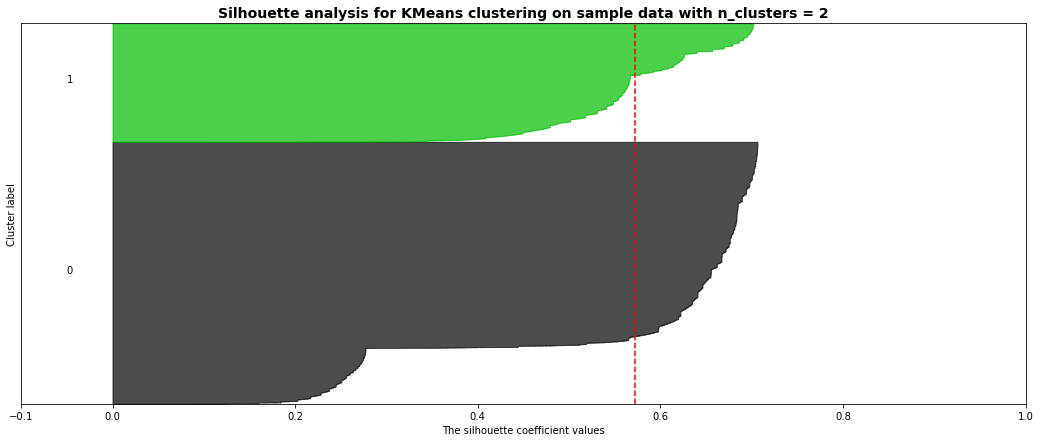

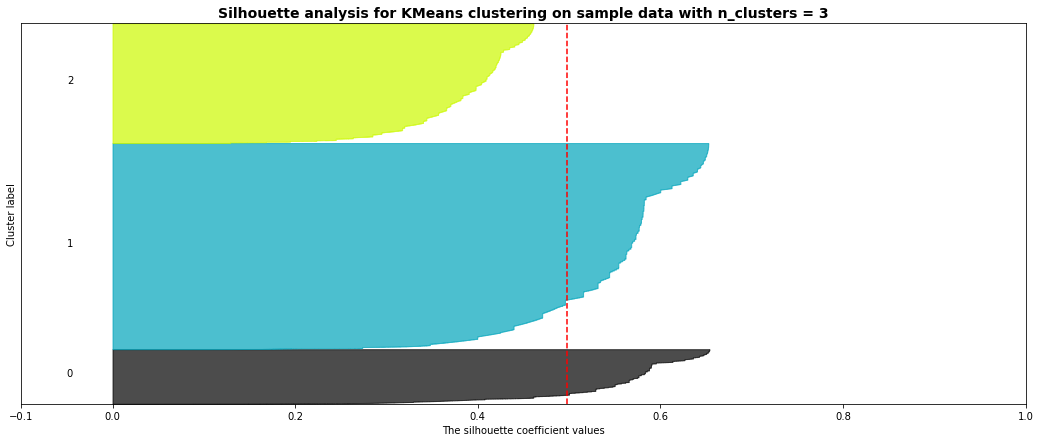

In [20]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
##Code adapted from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
##Generates plots that show the average silhouette score, as well as the scores for each point in each cluster
##Repeated for both k=2 and k=3
X = startTemp
range_n_clusters = [2, 3]
for n_clusters in range_n_clusters:
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
#     kModel = KMeans(n_clusters=i, random_state=5)
#     kMeansVal = kModel.fit_predict(X)
    sil_score = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        sil_score,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=sil_score, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)


    plt.title(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()